In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from itertools import combinations
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomNodeSplit
from sklearn.preprocessing import OneHotEncoder
import re

In [2]:
import torch

# Check if GPU is available
print("CUDA Available:", torch.cuda.is_available())

# Get the name of the GPU
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
Number of GPUs: 1


In [2]:
import numpy as np
import pandas as pd

def load_data(file_path):
    """
    Loads EEG dataset and identifies relevant columns.
    """
    df = pd.read_csv(file_path)
    target_col = "main.disorder"
    psd_columns = [col for col in df.columns if col.startswith("AB.")]
    coh_columns = [col for col in df.columns if col.startswith("COH.")]
    return df, target_col, psd_columns, coh_columns

def augment_psd(data, columns, target_col, noise_level=0.05):
    """
    Augments PSD values by adding Gaussian noise and increasing tail class counts.
    """
    class_counts = data[target_col].value_counts()
    max_samples = class_counts.max()
    augmented_data = data.copy()
    synthetic_samples = []
    
    column_std = data[columns].std()
    
    for disorder, count in class_counts.items():
        num_samples_needed = max_samples - count
        if num_samples_needed > 0:
            subset = data[data[target_col] == disorder]
            for _ in range(num_samples_needed):
                sample = subset.sample(n=1, replace=True).copy()
                noise = np.random.normal(loc=0, scale=noise_level * column_std, size=(1, len(columns)))
                sample[columns] += noise.flatten()
                synthetic_samples.append(sample)
    
    if synthetic_samples:
        augmented_data = pd.concat([augmented_data] + synthetic_samples, ignore_index=True)
    
    return augmented_data

def augment_coh(data, columns, target_col, noise_level=0.05):
    """
    Augments Coherence (FC) values by adding Gaussian noise and increasing tail class counts.
    """
    class_counts = data[target_col].value_counts()
    max_samples = class_counts.max()
    augmented_data = data.copy()
    synthetic_samples = []
    
    column_std = data[columns].std()
    
    for disorder, count in class_counts.items():
        num_samples_needed = max_samples - count
        if num_samples_needed > 0:
            subset = data[data[target_col] == disorder]
            for _ in range(num_samples_needed):
                sample = subset.sample(n=1, replace=True).copy()
                noise = np.random.normal(loc=0, scale=noise_level * column_std, size=(1, len(columns)))
                sample[columns] += noise.flatten()
                synthetic_samples.append(sample)
    
    if synthetic_samples:
        augmented_data = pd.concat([augmented_data] + synthetic_samples, ignore_index=True)
    
    return augmented_data

def preprocess_and_augment(file_path):
    """
    Loads dataset, applies augmentation, and returns processed data.
    """
    df, target_col, psd_columns, coh_columns = load_data(file_path)
    df = augment_psd(df, psd_columns, target_col)
    df = augment_coh(df, coh_columns, target_col)
    return df

def check_class_counts(df, target_col):
    """
    Prints the class distribution after augmentation.
    """
    class_counts = df[target_col].value_counts()
    print("Class Distribution After Augmentation:")
    print(class_counts)
    return class_counts


In [3]:
# Load EEG dataset
data_path = 'data/train.csv'  # Update if necessary
df = preprocess_and_augment(data_path)
check_class_counts(df, "main.disorder")

# Identify PSD and Coherence columns
psd_columns = [col for col in df.columns if col.startswith('AB.')]
coh_columns = [col for col in df.columns if col.startswith('COH.')]

# Extract unique electrodes from PSD column names
psd_electrodes = set()
for col in psd_columns:
    match = re.search(r'\.([A-Za-z0-9]+)$', col)
    if match:
        psd_electrodes.add(match.group(1))

# Extract unique electrodes from Coherence column names
coh_electrodes = set()
for col in coh_columns:
    match = re.search(r'COH\.[A-Za-z]+\.[A-Za-z]+\.[a-z]+\.([A-Za-z0-9]+)\.[a-z]+\.([A-Za-z0-9]+)', col)
    if match:
        coh_electrodes.add(match.group(1))
        coh_electrodes.add(match.group(2))

# Combine electrodes from PSD and Coherence
electrodes = sorted(psd_electrodes.union(coh_electrodes))

# Create a mapping for electrodes to indices
electrode_to_idx = {e: i for i, e in enumerate(electrodes)}
print(f" Extracted {len(electrodes)} unique electrodes.")

# Extract edges and weights using coherence values
edge_index = []
edge_weights = []
missing_electrodes = set()

for col in coh_columns:
    match = re.search(r'COH\.[A-Za-z]+\.[A-Za-z]+\.[a-z]+\.([A-Za-z0-9]+)\.[a-z]+\.([A-Za-z0-9]+)', col)
    if match:
        src, tgt = match.groups()
        if src in electrode_to_idx and tgt in electrode_to_idx:
            edge_index.append([electrode_to_idx[src], electrode_to_idx[tgt]])
            edge_weights.append(df[col].mean())
        else:
            missing_electrodes.add((src, tgt))

print(f" Successfully created {len(edge_index)} edges.")
print(f" Missing Electrodes for Edges: {missing_electrodes}")

# Convert edge list to tensor
if len(edge_index) > 0:
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
else:
    print(" Warning: No edges found!")

# Convert patient features (PSD & Coherence values)
num_patients = df.shape[0]
num_features_per_electrode = len(psd_columns) // len(electrodes)
patient_features = df[psd_columns].values.reshape(num_patients, len(electrodes), num_features_per_electrode)
patient_features_tensor = torch.tensor(patient_features, dtype=torch.float32)

# Extract labels
disorder_labels = df['main.disorder'].astype('category').cat.codes.values
target_tensor = torch.tensor(disorder_labels, dtype=torch.long)


# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
disorder_labels = df[['main.disorder']].astype('category')
disorder_labels_onehot = encoder.fit_transform(disorder_labels)
target_tensor = torch.tensor(disorder_labels_onehot, dtype=torch.float32)

Class Distribution After Augmentation:
main.disorder
Mood disorder                         250
Healthy control                       250
Schizophrenia                         250
Obsessive compulsive disorder         250
Addictive disorder                    250
Anxiety disorder                      250
Trauma and stress related disorder    250
Name: count, dtype: int64
 Extracted 19 unique electrodes.
 Successfully created 1026 edges.
 Missing Electrodes for Edges: set()


In [4]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class EEG_GAT(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes, num_heads=6):
        super(EEG_GAT, self).__init__()

        # Disorder-specific attention heads with adjusted feature targeting
        self.head_schizophrenia = GATConv(in_features, hidden_dim, heads=1, concat=True)  # Alpha PSD
        self.head_trauma = GATConv(in_features, hidden_dim, heads=1, concat=True)  # Beta FC
        self.head_anxiety = GATConv(in_features, hidden_dim, heads=1, concat=True)  # Whole band PSD
        self.head_mood = GATConv(in_features, hidden_dim, heads=1, concat=True)  # Theta FC
        self.head_addiction = GATConv(in_features, hidden_dim, heads=1, concat=True)  # Theta PSD
        self.head_ocd = GATConv(in_features, hidden_dim, heads=1, concat=True)  # Gamma FC

        # Final classifier layer
        self.fc = torch.nn.Linear(hidden_dim * num_heads, num_classes)

    def forward(self, x, edge_index):
        '''
        x: Node features (EEG data) with shape [num_nodes, num_features]
        edge_index: Graph structure (connectivity) with shape [2, num_edges]
        '''
        assert x.dim() == 2, "Input x must be [num_nodes, num_features]"
        assert edge_index.shape[0] == 2, "Edge index must be [2, num_edges]"

        # Feature selection based on disorder classification relevance
        alpha_psd_mask = x[:, :10]  # Alpha PSD for schizophrenia
        beta_fc_mask = x[:, 10:20]  # Beta FC for trauma
        whole_band_psd_mask = x[:, :]  # Whole Band PSD for anxiety
        theta_fc_mask = x[:, 20:30]  # Theta FC for mood disorders
        theta_psd_mask = x[:, 30:40]  # Theta PSD for addiction
        gamma_fc_mask = x[:, 40:50]  # Gamma FC for OCD

        # Apply GAT layers per disorder-specific feature
        out_schizophrenia = F.elu(self.head_schizophrenia(alpha_psd_mask, edge_index))
        out_trauma = F.elu(self.head_trauma(beta_fc_mask, edge_index))
        out_anxiety = F.elu(self.head_anxiety(whole_band_psd_mask, edge_index))
        out_mood = F.elu(self.head_mood(theta_fc_mask, edge_index))
        out_addiction = F.elu(self.head_addiction(theta_psd_mask, edge_index))
        out_ocd = F.elu(self.head_ocd(gamma_fc_mask, edge_index))

        # Concatenate outputs
        out = torch.cat([out_schizophrenia, out_trauma, out_anxiety, out_mood, out_addiction, out_ocd], dim=1)

        # Final classification
        out = self.fc(out)
        return F.log_softmax(out, dim=1)


In [ ]:
# # Training function

# model.to(device)

# # Move edge_index to GPU (assuming it doesn't change across batches)
# edge_index = edge_index.to(device)

# # Move entire dataset to GPU before training (optional, if memory allows)
# patient_features_tensor = patient_features_tensor.to(device)
# target_tensor = target_tensor.to(device)


def train(model, optimizer, patient_features_tensor, target_tensor, edge_index, batch_size=32, epochs=100):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        for i in range(len(patient_features_tensor) // batch_size):
            batch_x = patient_features_tensor[i * batch_size : (i + 1) * batch_size]
            batch_y = target_tensor[i * batch_size : (i + 1) * batch_size]

            # Ensure batch_x has correct shape
            if batch_x.dim() == 1:
                batch_x = batch_x.unsqueeze(0)

            output = model(batch_x, edge_index)
            loss = F.cross_entropy(output, batch_y.argmax(dim=1))
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return train_losses


# train_losses = []
# val_losses = []
# val_accuracies=[]
# # Training loop
# epochs = 100
# for epoch in range(epochs):
#     loss = train()  # Ensure no extra arguments
#     train_losses.append(loss)
#  # Store training loss
    
#     # Validation loss computation
#     model.eval()
#     with torch.no_grad():
#         batch_x = patient_features_tensor[:32]  # Use a small validation set
#         batch_y = target_tensor[:32]
#         output = model(batch_x, edge_index, batch_size=32)
#         val_loss = F.cross_entropy(output, batch_y.argmax(dim=1))
#         val_losses.append(val_loss)
        
#         # predicted = output.argmax(dim=1)
#         # correct = (predicted == batch_y).sum().item()
#         # val_accuracy = correct / len(batch_y) * 100  # Convert to percentage
#         # val_accuracies.append(val_accuracy)
    
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}: Train Loss {loss:.4f}, Validation Loss {val_loss:.4f}")

def load_data():
    # Load EEG data tensors (modify paths as needed)
    patient_features_tensor = torch.load("patient_features.pt")  # Shape: [num_nodes, num_features]
    target_tensor = torch.load("target_labels.pt")  # Shape: [num_nodes, num_classes]
    edge_index = torch.load("edge_index.pt")  # Shape: [2, num_edges]

    # Ensure data has correct shape
    if patient_features_tensor.dim() == 1:
        patient_features_tensor = patient_features_tensor.unsqueeze(0)  # Fix for single feature input

    edge_index = edge_index.to(torch.long)  # Ensure edge_index is integer

    return patient_features_tensor, target_tensor, edge_index



in_features = 50  # Adjust based on EEG feature count
hidden_dim = 64
num_classes = 6  # Number of psychiatric disorders
learning_rate = 0.001

# Load Data
patient_features_tensor, target_tensor, edge_index = load_data()

# Model & Optimizer
model = EEG_GAT(in_features, hidden_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train Model
train_losses = train(model, optimizer, patient_features_tensor, target_tensor, edge_index)

torch.save(model.state_dict(), 'data/gat_eeg_model.pth')


TypeError: load_data() missing 1 required positional argument: 'file_path'

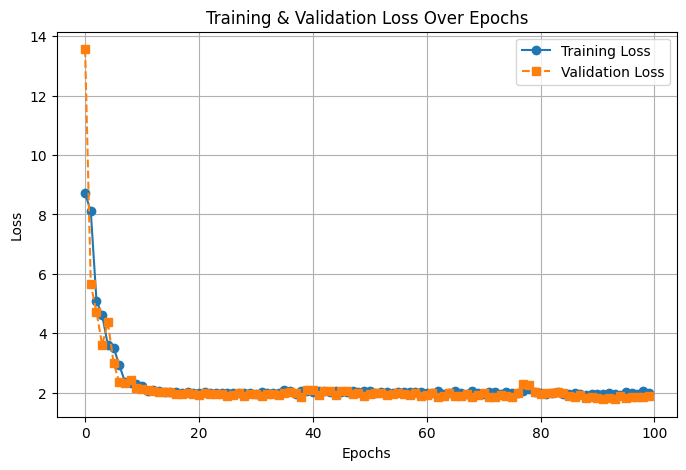

In [8]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_losses, label="Training Loss", marker="o", linestyle="-")
plt.plot(range(epochs), val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Define evaluation function
def evaluate(model, test_data_path, output_csv_path):
    test_df = pd.read_csv(test_data_path)
    test_patient_features = test_df[psd_columns].values.reshape(len(test_df), len(electrodes), num_features_per_electrode)
    test_patient_features_tensor = torch.tensor(test_patient_features, dtype=torch.float32)
    
    # One-hot encode test labels
    test_labels = test_df[['main.disorder']].astype('category')
    test_labels_onehot = encoder.transform(test_labels)
    test_labels_tensor = torch.tensor(test_labels_onehot, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        output = model(test_patient_features_tensor, edge_index, batch_size=len(test_df))
        predictions = output.argmax(dim=1).numpy()
        accuracy = (predictions == test_labels_tensor.argmax(dim=1).numpy()).sum().item() / len(test_df)
    
    print(f" Model Evaluation Accuracy: {accuracy:.4f}")
    
    # Save predictions to CSV
    test_df['predicted_disorder'] = encoder.categories_[0][predictions]
    test_df.to_csv(output_csv_path, index=False)
    print(f" Predictions saved to {output_csv_path}")
    
    return accuracy

# Load trained model and evaluate
test_data_path = 'data.csv'  
output_csv_path = 'data/predictions.csv'  
model.load_state_dict(torch.load('data/gat_eeg_model.pth'))
evaluate(model, test_data_path, output_csv_path)


 Model Evaluation Accuracy: 0.1290
 Predictions saved to data/predictions.csv


0.12903225806451613